# Feature engineering

- toc: true
- branch: master
- badges: true
- comments: false
- author: Kirtikumar Pandya
- categories: [fastpages, Feature engineering, Machine learning]

In [2]:
# hide
import pandas as pd
from scipy import stats

## Loading data

We will use famous Titanic dataset. We will use `pandas` to read csv file. If your dataset is large and cannot fit to your RAM, it is advisable to use `spark`.

In [3]:
# collapse
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


| Variable | Defination    | Key |
|--- |----------| ------|
| survival |	Survival |	0 = No, 1 = Yes|
| pclass |	Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd|
| sex |	Sex	| |
| Age |	Age  in years | |
|sibsp |	# of siblings / spouses aboard the Titanic | |
|parch | # of parents / children aboard the Titanic | |
|ticket |  Ticket number | |
|fare |	Passenger fare | |
|cabin | Cabin number | |
|embarked |	Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

In [4]:
#collapse
print(f"Titanic dataset has {titanic.shape[0]} entries and {titanic.shape[1]} features.")

Titanic dataset has 891 entries and 12 features.


## Data Exploration

### Continuous features

If we drop all categorical variables, it will look like below (Categirocal features are important but for now we will explore continuous features):

In [5]:
# collapse
cat_feat = ['PassengerId', 'Name', 'Ticket', 'Sex', 'Cabin', 'Embarked']
titanic.drop(cat_feat, axis=1, inplace=True)
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [6]:
# collapse
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Table above reveals that:

- Target variable `Survived` is binary with mean 0.38 which means <b>38%</b> of the people survived. Dataset is <b>not highly</b> imbalanced. In case of highly imbalanced dataset one should use oversampling or downsampling technique.
- `Pclass`, `SibSp` and `Parch` of descreate nature and have limited values.
- Titanic dataset has 819 entries but for `age` it shows only 714 entries. It means `Age` feature has <b> 177 missing values </b>. 

Now, let's explore correlation metrics. Keep in mind negative correlation is equally important as positive correlation. The features used to predict target varible should be less correlated with each other because it can confuse the model as it cannot parse out which feature the signal is comming from. 

In [7]:
# collapse
titanic.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


The target varible `Survived` has positive correlation with feature `Fare`. Passengers who bought costly ticket has higher chace of survival.

`Fare` and `Pclass` have negative correlation. It means ticket class 1 is the costliest and 3 is the cheapest. 

In [8]:
# collapse
titanic.groupby('Pclass')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


75 percentile of Pclass-1 > 75 percentile of Pclass-2 75 percentile of Pclass-3

In [9]:
# collapse
def describe_count_feature(feature):
    print(f"\n****** Result for {feature} ******")
    print(titanic.groupby('Survived')[feature].describe() )
    ttest(feature)
    
def ttest(feature):
    survived_feature = titanic[titanic.Survived == 1] [feature]
    not_survived_feature = titanic[titanic.Survived == 0] [feature]
    tstat, pval = stats.ttest_ind(survived_feature, not_survived_feature, equal_var=False)
    print(f"t-statistic: {tstat:.1f}, P-Vale: {pval:.3f}")
    
for feature in titanic.columns.drop('Survived'):
    describe_count_feature(feature)


****** Result for Pclass ******
          count      mean       std  min  25%  50%  75%  max
Survived                                                    
0         549.0  2.531876  0.735805  1.0  2.0  3.0  3.0  3.0
1         342.0  1.950292  0.863321  1.0  1.0  2.0  3.0  3.0
t-statistic: -10.3, P-Vale: 0.000

****** Result for Age ******
          count       mean        std   min   25%   50%   75%   max
Survived                                                           
0         424.0  30.626179  14.172110  1.00  21.0  28.0  39.0  74.0
1         290.0  28.343690  14.950952  0.42  19.0  28.0  36.0  80.0
t-statistic: nan, P-Vale: nan

****** Result for SibSp ******
          count      mean       std  min  25%  50%  75%  max
Survived                                                    
0         549.0  0.553734  1.288399  0.0  0.0  0.0  1.0  8.0
1         342.0  0.473684  0.708688  0.0  0.0  0.0  1.0  4.0
t-statistic: -1.2, P-Vale: 0.233

****** Result for Parch ******
          count 

Interestigly, <b>result for Fare</b> shows that average ticket cost of the survived passangers is higher than the passangers who did not surived. Similar difference can be observed for mean, median and inter quantile ranges. 

Average age of the survived passenger ➡️ 30.63 years <br>
Average age of the non-survived passenger ➡️ 28.34 years <br> 
However, 50 percentile for survived and not survived is the same.

We saw above that `Age` has 177 missing value. It is important to understand if the age is missing for certain group of people <u> OR</u> it is missing in systematic fasion. This will decide how we will handle the missing value.

In [10]:
# collapse
print(titanic.groupby(titanic.Age.isnull()).mean())
print('-----------')
print("⬆️ True indicates missing value.")

       Survived    Pclass        Age     SibSp     Parch       Fare
Age                                                                
False  0.406162  2.236695  29.699118  0.512605  0.431373  34.694514
True   0.293785  2.598870        NaN  0.564972  0.180791  22.158567
-----------
⬆️ True indicates missing value.


People without age reported are less likely to be survived, fewer parents/children, slightly higher class number and less fare.

### Visualize continuous features

Next, Let's plot the data to understand the distribution and the target variable.

In [13]:
# hide

!pip install seaborn
!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

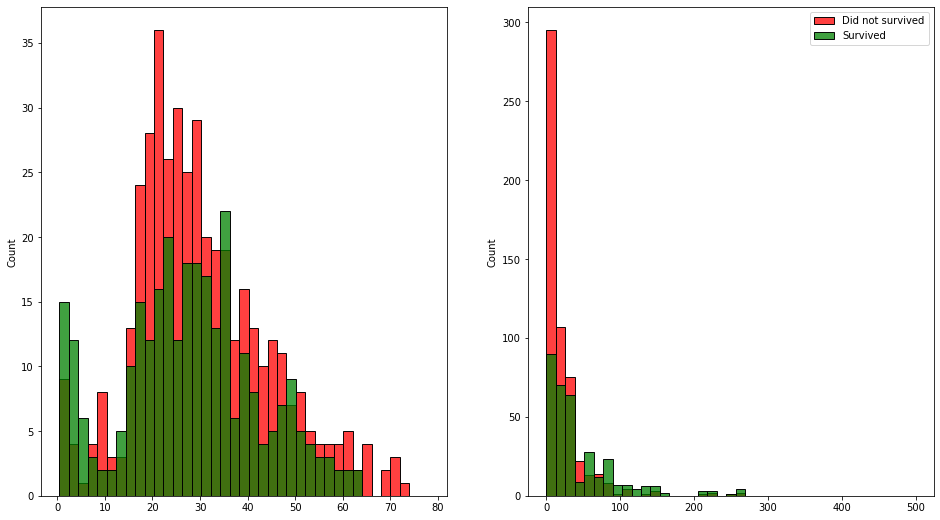

In [29]:
# collapse
fig, axs = plt.subplots(ncols=2, figsize=(16,9))
axs_no = 0

for feature in ['Age', 'Fare']:
    died = list(titanic[titanic.Survived == 0][feature].dropna())
    survived = list(titanic[titanic.Survived == 1][feature].dropna())
    xmin = min(min(died), min(survived))
    xmax = max( max(died), max(survived) )
    width = (xmax - xmin) / 40
    sns.histplot(died, color='r', kde=False, bins=np.arange(xmin, xmax, width), ax=axs[axs_no])
    sns.histplot(survived, color='g', kde=False, bins=np.arange(xmin, xmax, width), ax=axs[axs_no])
    axs_no += 1
    plt.legend(['Did not survived', 'Survived'])
    #plt.title(f"Histogram for {feature}")
    #plt.show()